# Monge-Ampère equations

In [1]:
import agd.LinearParallel as lp
import matplotlib.pyplot as plt
import numpy as np
from agd import Domain, Selling
from agd.AutomaticDifferentiation.Optimization import newton_root

In this notebook, we aim to solve Monge-Ampère equations of the form

$$ \det (D^2 u(x) - A(x, u(x), D u(x))) = B(x, u(x), D u(x)) $$

on an open domain $\Omega \subset \mathbb{R}^2$, for some given functions $A \colon \mathbb{R}^2 \times \mathbb{R} \times \mathbb{R}^2 \to \mathcal{S}_2$ and $B \colon \mathbb{R}^2 \times \mathbb{R} \times \mathbb{R}^2 \to \mathbb{R}$. We reformulate the Monge-Ampère equation in the form

$$ \sup_{\substack{\mathcal{D} \in \mathcal{S}_2^+ \\ \operatorname{Tr}(\mathcal{D}) = 1}} 2 (\det \mathcal{D})^{1/2} B(x, u(x), D^2 u(x))^{1/2} - \langle \mathcal{D}, D^2 u(x) - A(x, u(x), D^2 u(x)) \rangle = 0. $$

This reformulation satisfies two properties:

* It is *degenerate elliptic*, meaning that it may be written as

  $$ F(x, u(x), D u(x), D^2 u(x)) = 0, $$

  where the function $F \colon \mathbb{R}^2 \times \mathbb{R} \times \mathbb{R}^2 \times \mathcal{S}_2 \to \mathbb{R}$ is nonincreasing with respect to its last variable.

* It selects *admissible* solutions, that is, solutions $u \colon \Omega \to \mathbb{R}$ such that

  $$ D^2 u(x) - A(x, u(x), D u(x)) \geq 0. $$

## 1. The discretized equation

We discretize the reformulated equation on a grid $\mathcal{G}_h := \Omega \cap h \mathbb{Z}^2$, for some discretization step $h > 0$.

In [2]:
x = np.stack(np.meshgrid(*(2 * [np.linspace(-1, 1, 100)]), indexing="ij"))

The discretization of the equation is called *monotone* if the resulting numerical scheme may be written as

$$ F^h(x, u^h(x), u^h) = 0, $$

where $F^h \colon \mathcal{G}_h \times \mathbb{R} \times \mathbb{R}^{\mathcal{G}_h} \to \mathbb{R}$ is a function that is nonincreasing with respect to its last argument. Monotonicity is a discrete counterpart to degenerate ellipticity and is sometimes required for the scheme to be convergent.

Let $u \colon \Omega \to \mathbb{R}$ and $x \in \Omega$. We assume for now that $x$ is far from $\partial \Omega$. For any $e \in \mathbb{Z}^d$ such that $B_2(x, h |e|) \in \Omega$, we define

\begin{align*}
\delta_h^e u(x) &:= \frac{u(x + h e) - u(x)}{h}, &
\Delta_h^e u(x) &:= \frac{u(x + h e) + u(x - h e) - 2 u(x)}{h^2}.
\end{align*}

if $u \in C^4(\Omega)$, then

\begin{align*}
\delta_h^e u(x) &= \langle e, D u(x) \rangle + O(h), &
\Delta_h^e u(x) &= \langle e, D^2 u(x) e \rangle + O(h^2).
\end{align*}

We build a monotone finite difference scheme using the notion of superbase of $\mathbb{Z}^2$. A basis of $\mathbb{Z}^2$ is a pair of $v = (v_1, v_2)$ of vectors of $\mathbb{Z}^2$ such that $\det(v_1, v_2) = \pm 1$. A superbase of $\mathbb{Z}^2$ is a triplet $v = (v_1, v_2, v_3)$ of vectors of $\mathbb{Z}^2$ such that $(v_1, v_2)$ is a basis of $\mathbb{Z}^2$ and $v_3 = -v_1 - v_2$. Note that the definition is symmetric: $(v_1, v_3)$ and $(v_2, v_3)$ are also bases of $\mathbb{Z}^2$.

Let $\mathcal{D} \in \mathcal{S}_2$. If $v$ is a superbase of $\mathbb{Z}^2$, then we have Selling's formula:

$$ \mathcal{D} = -\sum_{1 \leq i \leq 3} \langle v_{i+1}, \mathcal{D} v_{i+2} \rangle v_i^\perp (v_i^\perp)^\top, $$

where indices are taken modulo three. The superbase $v$ is called *$\mathcal{D}$-obtuse* if $\langle v_i, \mathcal{D} v_j \rangle \leq 0$ for any $1 \leq i < j \leq 3$. If $v$ is $\mathcal{D}$-obtuse, we define the finite difference operator

$$ \Delta_h^{\mathcal{D}} u(x) := -\sum_{1 \leq i \leq 3} \langle v_{i+1}, \mathcal{D} v_{i+2} \rangle \Delta_h^{v_i^\perp} u(x). $$

By Selling's formula, if $u \in C^4(\Omega)$, then

$$ \Delta_h^{\mathcal{D}} u(x) = \langle \mathcal{D}, D^2 u(x) \rangle + O(h^2). $$

The $\mathcal{D}$-obtuseness of $v$ is required so that the operator $\Delta_h^{\mathcal{D}}$ may be used to build a monotone scheme. For any superbase $v$ of $\mathbb{Z}^2$, we define the set $\mathcal{S}_2^v \subset \mathcal{S}_d^+$ of matrices $\mathcal{D} \in \mathcal{S}_d^+$ such that $v$ is $\mathcal{D}$-obtuse. For any $\mu \geq 1$, Selling's algorithm maybe used to compute a set $V$ of superbases of $\mathbb{Z}^2$ such that $\cup_{v \in V} \mathcal{S}_2^v$ contains all matrices $\mathcal{D} \in \mathcal{S}_2^{++}$ whose condition number is less than or equal to $\mu$.

In [3]:
superbases = np.multiply.outer(
    Selling.SuperbasesForConditioning(15), np.ones(x.shape[1:], dtype=np.int64)
)

In [4]:
def MA(A, B, d2u, superbases):
    delta = d2u - lp.dot_VAV(
        lp.perp(superbases), A[:, :, np.newaxis, np.newaxis], lp.perp(superbases)
    )

    residue = -np.inf

    W = (
        -np.stack(
            [
                np.roll(superbases[0], 1, axis=0) * np.roll(superbases[0], 2, axis=0)
                - np.roll(superbases[1], 1, axis=0) * np.roll(superbases[1], 2, axis=0),
                np.roll(superbases[0], 1, axis=0) * np.roll(superbases[1], 2, axis=0)
                + np.roll(superbases[1], 1, axis=0) * np.roll(superbases[0], 2, axis=0),
            ]
        )
        / 2
    )
    w = -lp.dot_VV(np.roll(superbases, 1, axis=1), np.roll(superbases, 2, axis=1)) / 2

    q = lp.dot_AV(W, delta)
    r = np.sqrt(B + lp.dot_VV(q, q))

    residue = np.maximum(
        residue,
        np.max(
            np.where(
                np.all(lp.dot_VA(q, W) <= r * w, axis=0),
                r - lp.dot_VV(w, delta),
                -np.inf,
            ),
            axis=0,
        ),
    )

    bases = np.concatenate(
        [superbases[:, [0, 1]], superbases[:, [0, 2]], superbases[:, [1, 2]]], axis=2
    )
    delta_bases = np.concatenate([delta[[0, 1]], delta[[0, 2]], delta[[1, 2]]], axis=1)

    residue = np.maximum(
        residue,
        np.max(
            np.sqrt(
                B
                * lp.det(bases) ** 2
                / (
                    lp.dot_VV(bases[:, 0], bases[:, 0])
                    * lp.dot_VV(bases[:, 1], bases[:, 1])
                )
                + (
                    delta_bases[0] / lp.dot_VV(bases[:, 0], bases[:, 0])
                    - delta_bases[1] / lp.dot_VV(bases[:, 1], bases[:, 1])
                )
                ** 2
                / 4
            )
            - (
                delta_bases[0] / lp.dot_VV(bases[:, 0], bases[:, 0])
                + delta_bases[1] / lp.dot_VV(bases[:, 1], bases[:, 1])
            )
            / 2,
            axis=0,
        ),
    )

    return residue

## 2. Dirichlet boundary conditions

In [5]:
def SchemeDirichlet(u, x, domain, A, B, g, superbases):
    bc = Domain.Dirichlet(domain, g, x)

    du = bc.DiffCentered(u, [[1, 0], [0, 1]])
    d2u = bc.Diff2(u, lp.perp(superbases))

    return np.where(
        bc.interior, MA(A(x, u, du), B(x, u, du), d2u, superbases), u - bc.grid_values
    )

/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in less_equal
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in greater
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in less_equal
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Base.py:156: RuntimeWarning: invalid value encountered in greater
  return self.value.__array_ufunc__(ufunc,method,*inputs_,**kwargs)


Iteration: 1  Residue norm: 3.8923205646025547


Iteration: 2  Residue norm: 1.2872701009837755


Iteration: 3  Residue norm: 0.15508821829617014


Iteration: 4  Residue norm: 0.07236370901154093


Iteration: 5  Residue norm: 0.00892514430203839


Iteration: 6  Residue norm: 0.0005930582622555303


Iteration: 8  Residue norm: 9.136935652520606e-11
Target residue reached. Terminating.


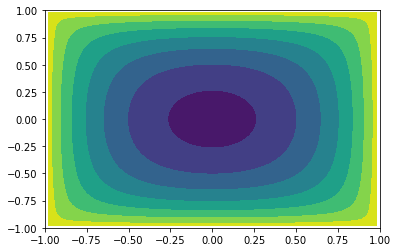

In [6]:
domain = Domain.Box([[-1, 1], [-1, 1]])


def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return np.ones(x.shape[1:])


u = newton_root(
    SchemeDirichlet, np.zeros(x.shape[1:]), (x, domain, A, B, 0.0, superbases)
)
u = np.where(domain.level(x) < 0, u, np.nan)

plt.contourf(*x, u)
plt.show()

### 2.1. Comparison with the exact solution

Iteration: 1  Residue norm: 73.38824828669112


Iteration: 2  Residue norm: 2.5289149038949263


Iteration: 3  Residue norm: 0.7503878059341889


Iteration: 4  Residue norm: 0.08520012557306544


Iteration: 5  Residue norm: 0.004053121782701563


Iteration: 6  Residue norm: 1.0534494084835089e-05


Iteration: 7  Residue norm: 6.760325632626518e-11
Target residue reached. Terminating.


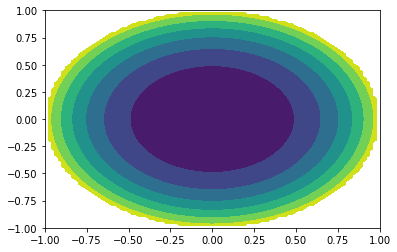

Error: 7.667856488336369e-05


In [7]:
domain = Domain.Ball()


def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return (4 + 32 * lp.dot_VV(x, x) + 48 * lp.dot_VV(x, x) ** 2) / 36


def Exact(x):
    return (lp.dot_VV(x, x) + lp.dot_VV(x, x) ** 2) / 6


u = newton_root(
    SchemeDirichlet, np.zeros(x.shape[1:]), (x, domain, A, B, 1 / 3, superbases)
)
u = np.where(domain.level(x) < 0, u, np.nan)

plt.contourf(*x, u)
plt.show()

err = np.where(domain.level(x) < 0, u - Exact(x), 0)
print("Error:", np.max(np.abs(err)))

Iteration: 1  Residue norm: 36654.50553736479


Iteration: 2  Residue norm: 8674.717093766165


Iteration: 3  Residue norm: 2035.9275470782238


Iteration: 4  Residue norm: 487.3753000166982


Iteration: 5  Residue norm: 118.7833238304581


Iteration: 6  Residue norm: 32.17804812794521


Iteration: 8  Residue norm: 92.45824056924926


Iteration: 10  Residue norm: 0.42407650415618026


Iteration: 12  Residue norm: 5.4434365681643726e-05


Iteration: 13  Residue norm: 3.0888092084069285e-10
Target residue reached. Terminating.


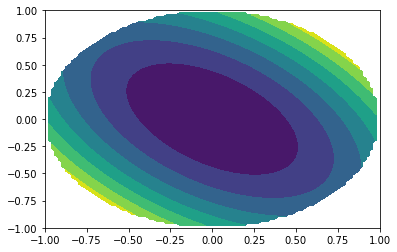

Error: 9.893138319005956e-06


In [8]:
Q = np.array([[2, 1], [1, 2]])
Q_inv = np.array([[2, -1], [-1, 2]]) / 3

assert np.allclose(Q @ Q_inv, np.eye(2))

domain = Domain.Ball()


def A(x, r, p):
    return -(
        r / 3 + lp.dot_VAV(p, np.multiply.outer(Q_inv, np.ones(x.shape[1:])), p) / 3
    ) * np.multiply.outer(Q, np.ones(x.shape[1:]))


def B(x, r, p):
    return (
        3
        * (
            1
            + 2 * r / 3
            + lp.dot_VAV(p, np.multiply.outer(Q_inv, np.ones(x.shape[1:])), p) / 6
        )
        ** 2
    )


def Exact(x):
    return lp.dot_VAV(x, np.multiply.outer(Q, np.ones(x.shape[1:])), x) / 2


u = newton_root(
    SchemeDirichlet, np.zeros(x.shape[1:]), (x, domain, A, B, Exact, superbases)
)
u = np.where(domain.level(x) < 0, u, np.nan)

plt.contourf(*x, u)
plt.show()

err = np.where(domain.level(x) < 0, u - Exact(x), 0)
print("Error:", np.max(np.abs(err)))

### 2.2. Other domains

Iteration: 1  Residue norm: 3.791943963628798


Iteration: 2  Residue norm: 1.1243754556408612


Iteration: 3  Residue norm: 0.14073444491339732


Iteration: 4  Residue norm: 0.04313700837978385


Iteration: 5  Residue norm: 0.00420841762238755


Iteration: 6  Residue norm: 6.915842973143072e-05


Iteration: 8  Residue norm: 5.895284260759581e-13
Target residue reached. Terminating.


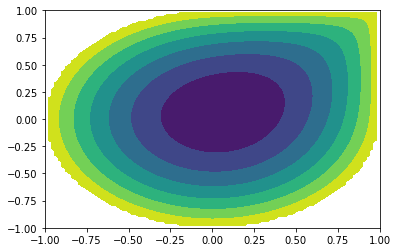

In [9]:
domain = Domain.Union(Domain.Ball(), Domain.Box())


def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return np.ones(x.shape[1:])


u = newton_root(
    SchemeDirichlet, np.zeros(x.shape[1:]), (x, domain, A, B, 0.0, superbases)
)
u = np.where(domain.level(x) < 0, u, np.nan)

plt.contourf(*x, u)
plt.show()

Iteration: 1  Residue norm: 42.75527340343402


Iteration: 2  Residue norm: 147.8676508983342


Iteration: 3  Residue norm: 103.55434260303394


Iteration: 4  Residue norm: 17.479988009476486


Iteration: 5  Residue norm: 0.6784819067407497


Iteration: 6  Residue norm: 5.98286705703884


Iteration: 8  Residue norm: 0.4037764796193133


Iteration: 10  Residue norm: 0.06553648664526313


Iteration: 12  Residue norm: 0.00042153997258154163


Iteration: 14  Residue norm: 9.101608355877033e-13
Target residue reached. Terminating.


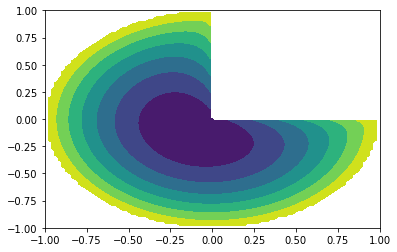

In [10]:
domain = Domain.Complement(Domain.Ball(), Domain.Box())


def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return np.ones(x.shape[1:])


u = newton_root(
    SchemeDirichlet, np.zeros(x.shape[1:]), (x, domain, A, B, 0.0, superbases)
)
u = np.where(domain.level(x) < 0, u, np.nan)

plt.contourf(*x, u)
plt.show()

## 3. Optimal transport boundary conditions

In [11]:
def SchemeBV2(u, x, domain, A, B, C, sigma, superbases):
    bc = Domain.Dirichlet(domain, np.inf, x)

    du0 = bc.DiffUpwind(u, [[1, 0], [0, 1]])
    du1 = bc.DiffUpwind(u, [[-1, 0], [0, -1]])
    # TODO
    assert np.sum(np.logical_and(du0 == np.inf, du1 == np.inf)) == 0
    du0 = np.where(du0 == np.inf, -du1, du0)
    du1 = np.where(du1 == np.inf, -du0, du1)
    du = (du0 - du1) / 2

    du0 = bc.DiffUpwind(u, lp.perp(superbases))
    du0 = np.where(
        du0 == np.inf,
        sigma(
            x[:, np.newaxis, np.newaxis],
            u[np.newaxis, np.newaxis],
            lp.perp(superbases),
        ),
        du0,
    )
    du1 = bc.DiffUpwind(u, -lp.perp(superbases))
    du1 = np.where(
        du1 == np.inf,
        sigma(
            x[:, np.newaxis, np.newaxis],
            u[np.newaxis, np.newaxis],
            -lp.perp(superbases),
        ),
        du1,
    )
    d2u = (du0 + du1) / bc.gridscale

    return np.where(
        bc.interior,
        MA(A(x, u, du), B(x, u, du), d2u, superbases)
        + u.flatten()[np.argmin(bc.domain.level(bc.grid))]
        - C,
        u - bc.grid_values,
    )

### 3.1. Comparison with the exact solution

Iteration: 1  Residue norm: 2069.1625072476563


Iteration: 2  Residue norm: 109.17028894909507


Iteration: 3  Residue norm: 37.087635039162926


Iteration: 4  Residue norm: 9.48820573079323


Iteration: 5  Residue norm: 3.1017757424223493


Iteration: 6  Residue norm: 0.5158981153606378


Iteration: 8  Residue norm: 0.00010778023556793498


Iteration: 9  Residue norm: 8.353108489622674e-09
Target residue reached. Terminating.


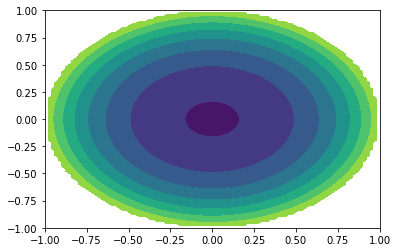

Error: 0.06925013758897941


In [12]:
domain = Domain.Ball()


def A(x, r, p):
    return np.zeros((2, 2) + x.shape[1:])


def B(x, r, p):
    return (4 + 32 * lp.dot_VV(x, x) + 48 * lp.dot_VV(x, x) ** 2) / 36


def sigma(x, r, e):
    return np.sqrt(lp.dot_VV(e, e))


def Exact(x):
    return (lp.dot_VV(x, x) + lp.dot_VV(x, x) ** 2) / 6


u = newton_root(
    SchemeBV2, np.zeros(x.shape[1:]), (x, domain, A, B, 0, sigma, superbases)
)
u = np.where(domain.level(x) < 0, u, np.nan)

plt.contourf(*x, u)
plt.show()

err = np.where(domain.level(x) < 0, u - Exact(x), 0)
print("Error:", np.max(np.abs(err)))

Iteration: 1  Residue norm: 21.88308012985028


Iteration: 2  Residue norm: 2.0376171082693957


Iteration: 3  Residue norm: 1.3040322188230213


Iteration: 4  Residue norm: 0.15809563451893274


Iteration: 5  Residue norm: 0.0019236615455323208


Iteration: 6  Residue norm: 2.231450664802459e-07


Iteration: 7  Residue norm: 6.088012038940604e-13
Target residue reached. Terminating.


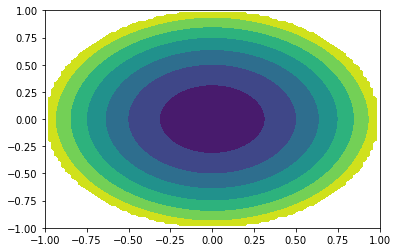

Error: 0.048291854590035155


In [13]:
domain = Domain.Ball()


def A(x, r, p):
    return -(r / 3 + lp.dot_VV(p, p) / 3) * lp.identity(x.shape[1:])


def B(x, r, p):
    return (1 + 2 * r / 3 + lp.dot_VV(p, p) / 6) ** 2


def sigma(x, r, e):
    return np.sqrt(lp.dot_VV(e, e))


def Exact(x):
    return lp.dot_VV(x, x) / 2


# TODO: initial guess
u = newton_root(SchemeBV2, lp.dot_VV(x, x), (x, domain, A, B, 0, sigma, superbases))
u = np.where(domain.level(x) < 0, u, np.nan)

plt.contourf(*x, u)
plt.show()

err = np.where(domain.level(x) < 0, u - Exact(x), 0)
print("Error:", np.max(np.abs(err)))

### 3.2. Near-field reflector design

/Users/guillaume/.pyenv/versions/3.8.2/envs/notebooks/lib/python3.8/site-packages/agd/AutomaticDifferentiation/Sparse.py:100: RuntimeWarning: divide by zero encountered in true_divide
  _concatenate(self.coef*_add_dim(1/other.value),other.coef*_add_dim(-self.value/other.value**2)),


Iteration: 1  Residue norm: 0.008581217955386355


Iteration: 2  Residue norm: 0.0017769330881758638


Iteration: 3  Residue norm: 0.000726181004131285


Iteration: 4  Residue norm: 1.3369011444733236e-05


Iteration: 5  Residue norm: 1.102535884811573e-08


Iteration: 6  Residue norm: 1.2827239270762902e-13
Target residue reached. Terminating.


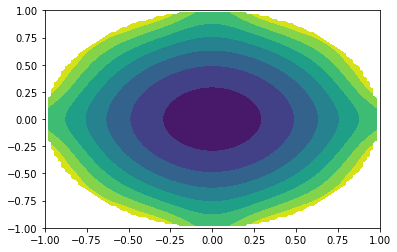

In [14]:
domain = Domain.Ball()


def f(x):
    return np.ones(x.shape[1:])


def A(x, r, p):
    tmp = 1 + np.sqrt(1 - lp.dot_VV(p, p) / r ** 4)
    return (2 + tmp) / r * lp.outer(p, p) - r ** 3 * tmp * lp.identity(x.shape[1:])


def B(x, r, p):
    tmp = 1 + np.sqrt(1 - lp.dot_VV(p, p) / r ** 4)
    return r ** 6 * (tmp ** 3 - tmp ** 2) * f(x)


def sigma(x, r, e):
    return 2 * r ** 3 * (np.sqrt(lp.dot_VV(e, e)) - lp.dot_VV(x, e))


u = newton_root(
    SchemeBV2, np.full(x.shape[1:], 0.1), (x, domain, A, B, 0.1, sigma, superbases),
)
u = np.where(domain.level(x) < 0, u, np.nan)

plt.contourf(*x, u)
plt.show()